# Some SPARQL queries
<div style="color: red; font-style: italic;">Note: when viewed through <span style="font-style: normal; font-weight: bold;">nbviewer</span> or converted through <span style="font-style: normal; font-weight: bold;">nbconvert</span> this notebook looks slightly different than when rendered by a running <em>sparqlkernel</em>. See a <a href="http://htmlpreview.github.io/?https://github.com/paulovn/sparql-kernel/blob/master/examples/sparql-endpoints.html">converted version</a> for an example more similar to the actual look in a "live" kernel.</div>


We are going to use some of the [Public SPARQL endpoints](https://www.w3.org/wiki/SparqlEndpoints). Let's look first at the set of available magics

In [1]:
%lsmagics

Available magics:
%display  %endpoint  %format  %graph  %lang  %log  %lsmagics  %outfile  %prefix  %show

%display raw | table [withtypes] | diagram [svg|png] [withliterals] : set display format
%endpoint url : set SPARQL endpoint. REQUIRED.
%format JSON | N3 | default : set requested result format
%graph uri : set default graph for the queries
%lang <lang> [...] | default | all : language(s) preferred for labels
%log critical | error | warning | info | debug : set logging level
%lsmagics  : list all magics
%outfile <filename> | NONE : save raw output to a file (use "%d" in name to add cell number)
%prefix uri : set a persistent URI prefix for all queries
%show <n> | all : maximum number of shown results

We set a few default options via those magics.

In [2]:
# Modify output format
# Don't show more than 80 results (event if more are fetched)
%show 80

# Request whatever format is appropriate for the query type
%format default

# Activate table output
%display table

Result maximum size: 80
Return format: DEFAULT
Display: table

## DBPedia

Note that DBPedia has a set of [predefined namespace prefixes](http://es.dbpedia.org/sparql?nsdecl) that we can use without the need to define them in the query.

### Simple queries

Find a few predicates that can point to people

In [3]:
%endpoint http://dbpedia.org/sparql
%display table withtypes

SELECT DISTINCT ?property
WHERE {
   ?s ?property ?person .
   ?person rdf:type foaf:Person .
}
LIMIT 10

Endpoint set to: http://dbpedia.org/sparql
Display: table
Show Types: on

property,type
http://dbpedia.org/ontology/wikiPageRedirects,uri
http://dbpedia.org/property/musicalguests,uri
http://dbpedia.org/property/otherp,uri
http://www.w3.org/2002/07/owl#sameAs,uri
http://dbpedia.org/property/after,uri
http://dbpedia.org/property/afterElection,uri
http://dbpedia.org/property/allWriting,uri
http://dbpedia.org/property/artist,uri
http://dbpedia.org/property/associatedActs,uri
http://dbpedia.org/property/before,uri


Let's use the `dbp:before` predicate to find chains of at least 4 persons that form a sequence. Since it can produce a nice graph, let's output it as a diagram.

Endpoint set to: http://dbpedia.org/sparql
Display: svg

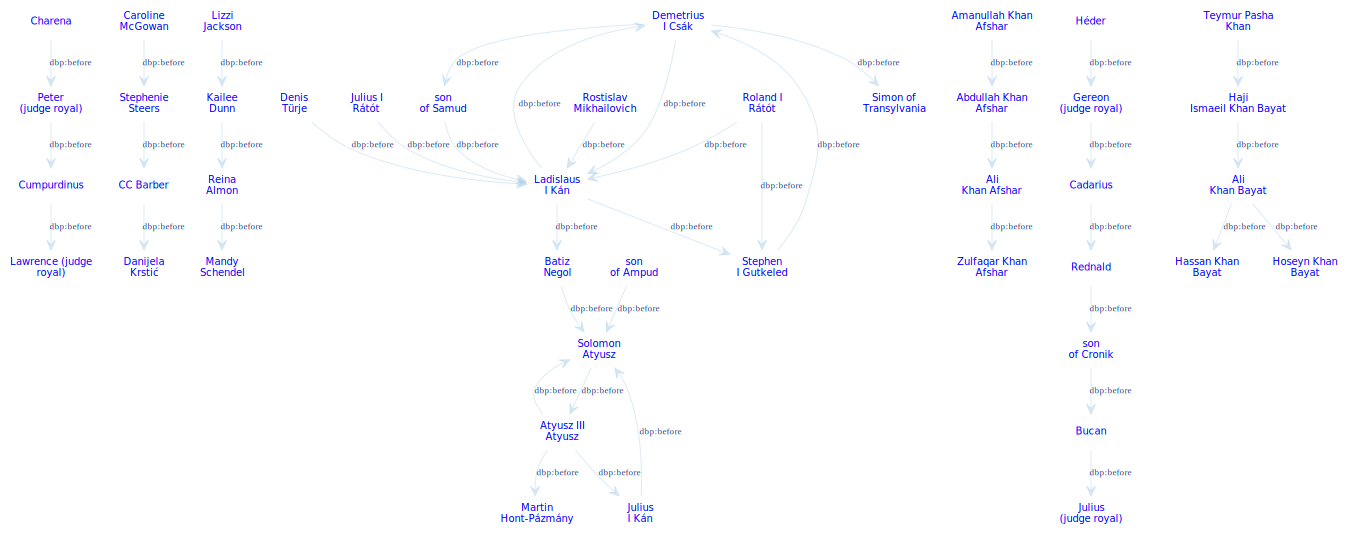

In [4]:
%endpoint http://dbpedia.org/sparql
%display diagram

CONSTRUCT {
    ?p1 dbp:before ?p2 .
    ?p2 dbp:before ?p3 .
    ?p3 dbp:before ?p4 .
}
WHERE {
    ?p1 rdf:type foaf:Person .
    ?p1 dbp:before ?p2 .
    ?p2 dbp:before ?p3 .
    ?p3 dbp:before ?p4 .
}
LIMIT 50

A `DESCRIBE` query, also represented as a diagram.

In [5]:
%endpoint http://dbpedia.org/sparql
%display diagram
%lang es
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
DESCRIBE <http://dbpedia.org/resource/Asturias>
LIMIT 10

Endpoint set to: http://dbpedia.org/sparql
Display: svg
Label preferred languages: ['es']

### Elaborate queries

#### Example 1
This one is taken from [SPARQL By Example](https://www.w3.org/2009/Talks/0615-qbe/#q5):

* Find out all countries without coastline and population greater than 15M. 
* Ordered by population

In [6]:
%endpoint http://dbpedia.org/sparql
%format default
%display table 
%lang all

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>        
PREFIX type: <http://dbpedia.org/class/yago/>
PREFIX prop: <http://dbpedia.org/property/>
SELECT ?country_name ?population
WHERE {
    ?country a type:LandlockedCountries ;
             rdfs:label ?country_name ;
             prop:populationEstimate ?population .
    FILTER (?population > 15000000) .
    FILTER (langMatches(lang(?country_name), "EN")) .
} ORDER BY DESC(?population)

Endpoint set to: http://dbpedia.org/sparql
Return format: DEFAULT
Display: table
Label preferred languages: []

country_name,population
Ethiopia,90076012
Afghanistan,32564342
Uzbekistan,31025500
Kazakhstan,17563300
Burkina Faso,17322796
Malawi,16407000
Zambia,16212000


#### Example 2
Where was Henrik Ibsen born? (taken from a [StackOverflow answer](http://stackoverflow.com/a/21859115)).

In [7]:
%endpoint http://dbpedia.org/sparql
%display table withtypes
%lang all

PREFIX dbpedia-owl: <http://dbpedia.org/ontology/>
SELECT ?label { 
 dbr:Henrik_Ibsen
   dbpedia-owl:birthPlace
     [ a dbpedia-owl:Country ;
       rdfs:label ?label ]
 FILTER langMatches(lang(?label),"en")
}

Endpoint set to: http://dbpedia.org/sparql
Display: table
Show Types: on
Label preferred languages: []

label,type
Norway,"literal, en"


## Wikidata
Let's use now the [wikidata](http://wikidata.org) SPARQL endpoint query service. You can read its [user manual](https://www.mediawiki.org/wiki/Wikidata_query_service/User_Manual). There is also a page with many [example queries](https://www.mediawiki.org/wiki/Wikibase/Indexing/SPARQL_Query_Examples)

### Example 1
This was taken from [Causes of death for US presidents](http://ramiro.org/notebook/us-presidents-causes-of-death/)

In [8]:
%endpoint http://query.wikidata.org/sparql
%display table
%show all

PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?president ?cause ?dob ?dod WHERE {
    ?pid wdt:P39 wd:Q11696 .
    ?pid wdt:P509 ?cid .
    ?pid wdt:P569 ?dob .
    ?pid wdt:P570 ?dod .

    OPTIONAL {
        ?pid rdfs:label ?president filter (lang(?president) = "en") .
    }
    OPTIONAL {
        ?cid rdfs:label ?cause filter (lang(?cause) = "en") .
    }
}

Endpoint set to: http://query.wikidata.org/sparql
Display: table
Result maximum size: unlimited

president,cause,dob,dod
Ronald Reagan,Alzheimer's disease,1911-02-06T00:00:00Z,2004-06-05T00:00:00Z
Zachary Taylor,cholera,1784-11-24T00:00:00Z,1850-07-09T00:00:00Z
James K. Polk,cholera,1795-11-02T00:00:00Z,1849-06-15T00:00:00Z
Calvin Coolidge,heart attack,1872-07-04T00:00:00Z,1933-01-05T00:00:00Z
Rutherford B. Hayes,heart attack,1822-10-04T00:00:00Z,1893-01-17T00:00:00Z
Warren G. Harding,heart attack,1865-11-02T00:00:00Z,1923-08-02T00:00:00Z
Grover Cleveland,heart attack,1837-03-18T00:00:00Z,1908-06-24T00:00:00Z
Lyndon B. Johnson,heart attack,1908-08-27T00:00:00Z,1973-01-22T00:00:00Z
Benjamin Harrison,pneumonia,1833-08-20T00:00:00Z,1901-03-13T00:00:00Z
Martin Van Buren,pneumonia,1782-12-05T00:00:00Z,1862-07-24T00:00:00Z


### Example 2
Birthdays for today. We fetch only the oldest 20 (depending on the date, there could be many). Example from the [wikidata example list](https://www.mediawiki.org/wiki/Wikibase/Indexing/SPARQL_Query_Examples#Whose_birthday_is_today.3F)

In [9]:
%endpoint http://query.wikidata.org/sparql

SELECT ?entityS ?entity (year(?date) as ?year) 
WHERE 
{
    ?entityS wdt:P569 ?date .
    SERVICE wikibase:label {
        bd:serviceParam wikibase:language "en" .
        ?entityS rdfs:label ?entity
    } 
    FILTER (datatype(?date) = xsd:dateTime && month(?date) = month(now()) && day(?date) = day(now()))
}
ORDER BY ASC(?year)
LIMIT 20

Endpoint set to: http://query.wikidata.org/sparql

entityS,entity,year
http://www.wikidata.org/entity/Q362113,William Adelin,1103
http://www.wikidata.org/entity/Q156147,Ladislaus IV of Hungary,1262
http://www.wikidata.org/entity/Q2288858,Moriyoshi-shinnō,1308
http://www.wikidata.org/entity/Q6798541,Siraj al-Din al-Bulqini,1324
http://www.wikidata.org/entity/Q444658,"Louis II, Duke of Bourbon",1337
http://www.wikidata.org/entity/Q2663119,"Jorge de Lencastre, 2nd Duke of Coimbra",1481
http://www.wikidata.org/entity/Q3292910,Maria of Jülich-Berg,1491
http://www.wikidata.org/entity/Q16863531,William Waldegrave,1507
http://www.wikidata.org/entity/Q5948809,Q5948809,1519
http://www.wikidata.org/entity/Q98742,Jacob Heerbrand,1521


### Example 3

Who discovered the most asteroids?. Taken also from the [example page](https://www.mediawiki.org/wiki/Wikibase/Indexing/SPARQL_Query_Examples#Who_discovered_the_most_asteroids.3F)

In [10]:
%endpoint http://query.wikidata.org/sparql
%display table
SELECT ?discoverer ?name (COUNT(?asteroid) AS ?count)
WHERE
{
    ?asteroid wdt:P31 wd:Q3863 .
    ?asteroid wdt:P61 ?discoverer .
    SERVICE wikibase:label {
        bd:serviceParam wikibase:language "en" .
        ?discoverer rdfs:label ?name
    }
}
GROUP BY ?discoverer ?name
ORDER BY DESC(?count)
LIMIT 10

Endpoint set to: http://query.wikidata.org/sparql
Display: table

discoverer,name,count
http://www.wikidata.org/entity/Q735603,Lincoln Near-Earth Asteroid Research,16457
http://www.wikidata.org/entity/Q213563,Spacewatch,3215
http://www.wikidata.org/entity/Q312255,Tom Gehrels,2287
http://www.wikidata.org/entity/Q231642,Ingrid van Houten-Groeneveld,2272
http://www.wikidata.org/entity/Q336095,Cornelis Johannes van Houten,2271
http://www.wikidata.org/entity/Q312755,Eric Walter Elst,2133
http://www.wikidata.org/entity/Q1165635,Lowell Observatory Near-Earth-Object Search,1755
http://www.wikidata.org/entity/Q1140499,Near-Earth Asteroid Tracking,1557
http://www.wikidata.org/entity/Q814731,Beijing Schmidt CCD Asteroid Program,1237
http://www.wikidata.org/entity/Q446449,Schelte J. Bus,1101


## Linkedmdb

[linkedMDB](http://data.linkedmdb.org/) contains an RDF database for Movies. It also has a web-based [query interface](http://data.linkedmdb.org/snorql/)

Let's find movie titles with the `ring` word in it.

In [11]:
%endpoint http://data.linkedmdb.org/sparql
%format json
%display table

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX movie: <http://data.linkedmdb.org/resource/movie/>
SELECT ?movie ?label
WHERE {
    ?movie rdf:type movie:film .
    ?movie rdfs:label ?label .
    FILTER regex(?label, "ring", "i")
} LIMIT 10


Endpoint set to: http://data.linkedmdb.org/sparql
Return format: JSON
Display: table

movie,label
http://data.linkedmdb.org/resource/film/20,Manufacturing Consent: Noam Chomsky and the Media
http://data.linkedmdb.org/resource/film/463,The Lord of the Rings: The Fellowship of the Ring
http://data.linkedmdb.org/resource/film/464,The Lord of the Rings: The Two Towers
http://data.linkedmdb.org/resource/film/465,The Lord of the Rings: The Return of the King
http://data.linkedmdb.org/resource/film/480,Ring
http://data.linkedmdb.org/resource/film/839,The Lord of the Rings
http://data.linkedmdb.org/resource/film/1366,"Spring, Summer, Fall, Winter... and Spring"
http://data.linkedmdb.org/resource/film/1386,Bring It On
http://data.linkedmdb.org/resource/film/1456,Dead Ringers
http://data.linkedmdb.org/resource/film/1472,Babylon 5: The Gathering


<div style="border-top: 1px gray solid; font-family: Cursive, sans-serif;">Version: 1.1 (2016-08-10)<br/>
Author: Paulo Villegas</div>